# Batch Regression models

In [247]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.metrics import mean_squared_error

In [248]:
#Define ticker
SP500 = '^GSPC'
CAC40 = '^FCHI'
Nikkei225 = '^N225'

#Recover Data
SP500_ticker = yf.Ticker(SP500)
CAC40_ticker = yf.Ticker(CAC40)
Nikkei225_ticker = yf.Ticker(Nikkei225)

#Recover prices
SP500_data = SP500_ticker.history(start='2000-01-01')
CAC40_data = CAC40_ticker.history(start='2000-01-01')
Nikkei225_data = Nikkei225_ticker.history(start='2000-01-01')

In [249]:
SP500_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


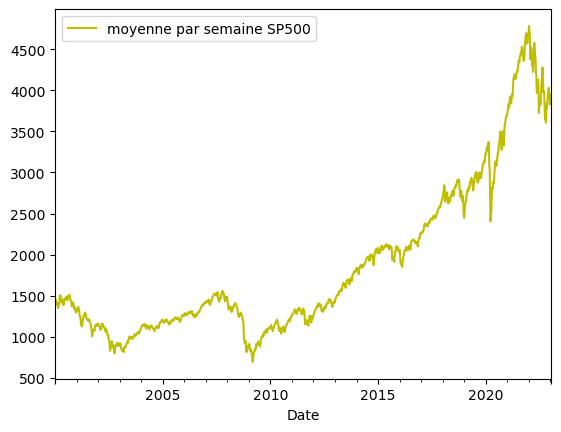

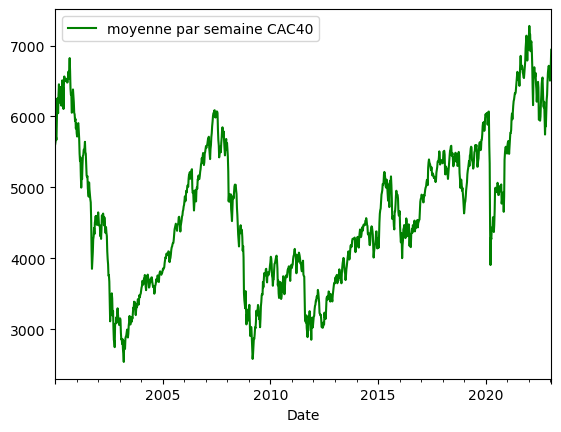

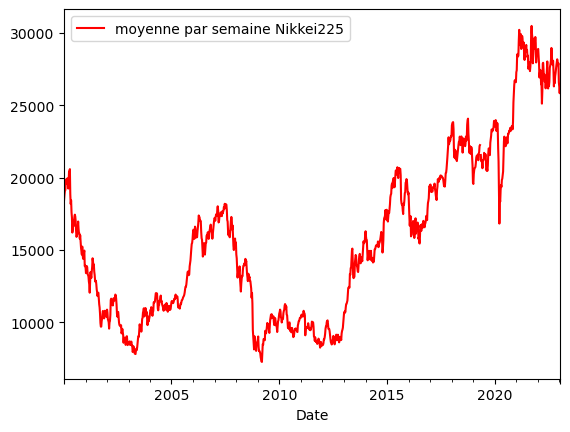

In [250]:
SP = SP500_data['Close'].resample('W').agg(['mean', 'std', 'min', 'max'])
CAC = CAC40_data['Close'].resample('W').agg(['mean', 'std', 'min', 'max'])
Nikkei = Nikkei225_data['Close'].resample('W').agg(['mean', 'std', 'min', 'max'])

plt.figure()
SP['mean'].plot(label='moyenne par semaine SP500', c='y')
plt.legend()

plt.figure()
CAC['mean'].plot(label='moyenne par semaine CAC40', c='g')
plt.legend()

plt.figure()
Nikkei['mean'].plot(label='moyenne par semaine Nikkei225', c ='r')
plt.legend()

plt.show()

# Basic functions

In [251]:
predict_every = 120
predict_during = 30
firstpredict = 480

In [252]:
def train_true(df,predict_every,predict_during, diff=1):
    list_df_train = []
    list_df_true = []
    nb_dataset = (len(df) // predict_every) - 3
    df['label'] = df['Close'].shift(-diff)
    for i in range(0,nb_dataset):
        train_i = df[:firstpredict+i*predict_every]
        list_df_train.append(train_i)
        true_i = df['Close'][i*predict_every:i*predict_every+predict_during]
        list_df_true.append(true_i)
    
    return list_df_train, list_df_true

In [253]:
def plot_results(pred):
    # nombre de lignes et de colonnes de la grille de tracé
    n_rows = 12
    n_cols = 4

    # créer une figure
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 60))
    
    rmses = []
    # itérer à travers les dataframes
    for i,df in enumerate(pred):
        # calculer les indices de ligne et de colonne pour tracer le dataframe
        row = i // n_cols
        col = i % n_cols
        # tracer le dataframe
        rmse = mean_squared_error(df['Close'],df[0],squared=False)
        rmses.append(rmse)
        df.plot(ax=axs[row][col], title=f'{rmse}')
        
    print('RMSE :', np.mean(rmses))

    # afficher la figure
    plt.show()

In [254]:
def obtain_rmse(pred,name_model):
    dates = []
    rmses = []
    for df in pred:
        date = df.index[0]
        rmse = mean_squared_error(df['Close'],df[0],squared=False)
        dates.append(date)
        rmses.append(rmse)
    data = {'date':dates, name_model:rmses}
    result_df = pd.DataFrame(data)
    result_df.set_index('date', inplace=True)
    global_rmse = np.mean(rmses)
    data1 = {'model':name_model, 'RMSE':[global_rmse]}
    rmse_df = pd.DataFrame(data1)
    
    return result_df, rmse_df
    

In [255]:
def obtain_rmses(preds,name_models):
    for i, (pred,name) in enumerate(zip(preds,name_models)):
        result_df, rmse_df = obtain_rmse(pred,name)
        if i == 0 :
            merge_results, rmses_df = result_df, rmse_df
        else:
            merge_results = pd.merge(merge_results,result_df,left_index=True,right_index=True)
            rmses_df = pd.concat([rmses_df,rmse_df], ignore_index=True)
            
    return merge_results,rmses_df

## Holt-Winters Exponential Smoothing

In [256]:
from statsmodels.tsa.api import ExponentialSmoothing

def HoltWinters(list_train,list_true):
    list_pred = []
    for train_data, true_data in zip(list_train,list_true):
        hw = ExponentialSmoothing(np.array(train_data['Close']), trend='add', seasonal='add',seasonal_periods=24).fit()
        hw_pred = hw.forecast(predict_during)
        series_pred = pd.Series(hw_pred, index = true_data.index)
        list_pred.append(pd.concat([true_data,series_pred], axis=1))
    
    return list_pred

def HoltWinters_constant(list_train,list_true):
    list_pred = []
    for train_data, true_data in zip(list_train,list_true):
        hw = ExponentialSmoothing(np.array(train_data['Close'])).fit()
        hw_pred = hw.forecast(predict_during)
        series_pred = pd.Series(hw_pred, index = true_data.index)
        list_pred.append(pd.concat([true_data,series_pred], axis=1))
    
    return list_pred

## SARIMAX

In [257]:
from statsmodels.tsa.statespace.sarimax import *

def Snarimax(list_train,list_true):
    list_pred = []
    for train_data, true_data in zip(list_train,list_true):
        snarimax = SARIMAX(np.array(train_data['Close']), order=(1,1,1), seasonal_order=(0,1,1,24)).fit()
        Sarimax_pred = snarimax.forecast(predict_during)
        series_pred = pd.Series(Sarimax_pred, index = true_data.index)
        list_pred.append(pd.concat([true_data,series_pred], axis=1))
    
    return list_pred

# Rolling Linear Regression

In [258]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

def RollingRegression(list_train,list_true,predict_during):
    list_pred = []
    for train_data, true_data in zip(list_train,list_true):
        label = train_data['label']
        train_data1 = train_data.copy().drop(columns=['Open','Dividends', 'Stock Splits','label'])
        scaler = StandardScaler()
        scaler.fit(train_data1)
        train_data1 = scaler.transform(train_data1)
        
        lr = LinearRegression()
        lr.fit(train_data1,label)
        
        roll_reg_pred = lr.predict(train_data1[-predict_during:])
        series_pred = pd.Series(roll_reg_pred, index = true_data.index)
        list_pred.append(pd.concat([true_data,series_pred], axis=1))
        
    return list_pred

# SP500 Predictions

## Predictions with Holtwinters and Snarimax

In [259]:
list_SP500_train, list_SP500_true = train_true(SP500_data,predict_every,predict_during)
hw_SP500_pred = HoltWinters(list_SP500_train,list_SP500_true)
hw_SP500_pred_constant = HoltWinters_constant(list_SP500_train,list_SP500_true)
snarimax_SP500_pred = Snarimax(list_SP500_train,list_SP500_true)

C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Predictions with Rolling Linear Regression

In [260]:
list_SP500_train, list_SP500_true = train_true(SP500_data,predict_every,predict_during,diff=predict_during)
rollreg_SP500_pred = RollingRegression(list_SP500_train,list_SP500_true,predict_during)

## Merge SP500 predictions

In [261]:
results_SP500, RMSE_SP500 = obtain_rmses([hw_SP500_pred,hw_SP500_pred_constant,snarimax_SP500_pred,rollreg_SP500_pred],['Holtwinters','Holtwinters_contant','Snarimax','Rolling Linear Regression'])

In [262]:
results_SP500

,Holtwinters,Holtwinters_contant,Snarimax,Rolling Linear Regression
date,,,,
2000-01-03 00:00:00-05:00,282.447578,283.387758,310.306447,304.227395
2000-06-23 00:00:00-04:00,401.302478,381.828608,397.738989,386.665598
2000-12-13 00:00:00-05:00,461.351884,442.533220,457.449549,455.501285
2001-06-07 00:00:00-04:00,312.039087,301.603407,342.475935,334.145188
2001-12-03 00:00:00-05:00,110.993749,103.012010,109.818750,128.623354
2002-05-28 00:00:00-04:00,122.459129,117.884996,115.216010,110.715230
2002-11-14 00:00:00-05:00,218.987424,214.718459,209.447913,201.061382
2003-05-09 00:00:00-04:00,213.779958,217.552407,213.086303,228.702380
2003-10-29 00:00:00-05:00,163.401519,161.731909,159.644895,171.723807


In [263]:
RMSE_SP500

,model,RMSE
0,Holtwinters,385.481611
1,Holtwinters_contant,377.527324
2,Snarimax,382.871587
3,Rolling Linear Regression,384.181820


<Figure size 640x480 with 0 Axes>

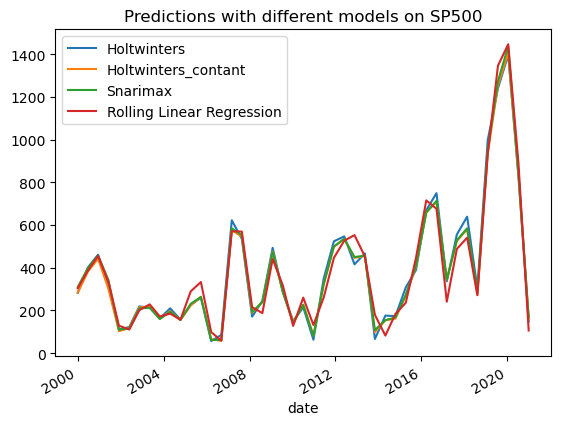

In [295]:
plt.figure()
results_SP500.plot()
plt.title('Predictions with different models on SP500')
plt.legend()
plt.savefig('batch/SP500_predictions.png')
plt.show()

# CAC40 Predictions

## Predictions with Holtwinters and Snarimax

In [265]:
list_CAC40_train, list_CAC40_true = train_true(CAC40_data,predict_every,predict_during)
hw_CAC40_pred = HoltWinters(list_CAC40_train,list_CAC40_true)
hw_CAC40_pred_constant = HoltWinters_constant(list_CAC40_train,list_CAC40_true)
snarimax_CAC40_pred = Snarimax(list_CAC40_train,list_CAC40_true)

C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## Predictions with Rolling Linear Regression

In [279]:
list_CAC40_train, list_CAC40_true = train_true(CAC40_data,predict_every,predict_during,diff=predict_during)
rollreg_CAC40_pred = RollingRegression(list_CAC40_train[:-1],list_CAC40_true[:-1],predict_during)

## Merge CAC40 predictions

In [280]:
results_CAC40, RMSE_CAC40 = obtain_rmses([hw_CAC40_pred,hw_CAC40_pred_constant,snarimax_CAC40_pred,rollreg_CAC40_pred],['Holtwinters','Holtwinters_contant','Snarimax','Rolling Linear Regression'])

In [284]:
RMSE_CAC40

,model,RMSE
0,Holtwinters,1057.468421
1,Holtwinters_contant,981.396693
2,Snarimax,986.900859
3,Rolling Linear Regression,954.127810


<Figure size 640x480 with 0 Axes>

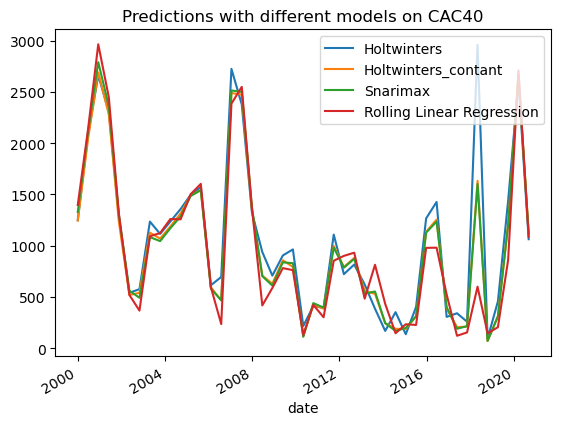

In [294]:
plt.figure()
results_CAC40.plot()
plt.title('Predictions with different models on CAC40')
plt.legend()
plt.savefig('batch/CAC40_predictions.png')
plt.show()

# Nikkei225 Predictions

## Predictions with Holtwinters and Snarimax

In [286]:
list_Nikkei225_train, list_Nikkei225_true = train_true(Nikkei225_data,predict_every,predict_during)
hw_Nikkei225_pred = HoltWinters(list_Nikkei225_train,list_Nikkei225_true)
hw_Nikkei225_pred_constant = HoltWinters_constant(list_Nikkei225_train,list_Nikkei225_true)
snarimax_Nikkei225_pred = Snarimax(list_Nikkei225_train,list_Nikkei225_true)

C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

## Predictions with Rolling Linear Regression

In [288]:
list_Nikkei225_train, list_Nikkei225_true = train_true(Nikkei225_data,predict_every,predict_during,diff=predict_during)
rollreg_Nikkei225_pred = RollingRegression(list_Nikkei225_train[:-1],list_Nikkei225_true[:-1],predict_during)

## Merge Nikkei225 predictions

In [289]:
results_Nikkei225, RMSE_Nikkei225 = obtain_rmses([hw_Nikkei225_pred,hw_Nikkei225_pred_constant,snarimax_Nikkei225_pred,rollreg_Nikkei225_pred],['Holtwinters','Holtwinters_contant','Snarimax','Rolling Linear Regression'])

In [290]:
RMSE_Nikkei225

,model,RMSE
0,Holtwinters,3734.475511
1,Holtwinters_contant,3659.660591
2,Snarimax,3691.604834
3,Rolling Linear Regression,3668.793532


<Figure size 640x480 with 0 Axes>

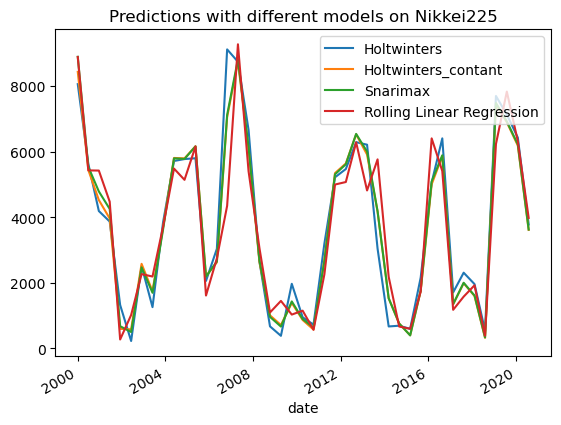

In [296]:
plt.figure()
results_Nikkei225.plot()
plt.title('Predictions with different models on Nikkei225')
plt.legend()
plt.savefig('batch/Nikkei255_predictions.png')
plt.show()

# Performances

In [293]:
performances = pd.concat({'SP500': RMSE_SP500, 'CAC40': RMSE_CAC40, 'Nikkei225': RMSE_Nikkei225})
performances

model         RMSE
SP500     0                Holtwinters   385.481611
          1        Holtwinters_contant   377.527324
          2                   Snarimax   382.871587
          3  Rolling Linear Regression   384.181820
CAC40     0                Holtwinters  1057.468421
          1        Holtwinters_contant   981.396693
          2                   Snarimax   986.900859
          3  Rolling Linear Regression   954.127810
Nikkei225 0                Holtwinters  3734.475511
          1        Holtwinters_contant  3659.660591
          2                   Snarimax  3691.604834
          3  Rolling Linear Regression  3668.793532